## Advanced Lane Finding Project


Steps for the pipeline are;

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Detect lane lines
1. Determine the lane curvature


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



## Calibrate The Camera

In [2]:
class CalibrateCamera:
    # Note these are class variables, so you only every have to read images once
    ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
    objpoints = []
    imgpoints = []
    cal_images = []
    
    def __init__(self):
        self.readCalibrationImages()

    def readCalibrationImages(self):
        if len (self.cal_images) > 0:
            return
        # prepare object points
        nx = 9 #TODO: enter the number of inside corners in x
        ny = 6 #TODO: enter the number of inside corners in y

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coord

        images = glob.glob("./camera_cal/*.jpg")

        # Make a list of calibration images

        for fname in images:
            print (fname)
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                #print (corners[0], corners[nx-1],corners[-1],corners[-nx])

            self.cal_images.append((img,fname))

    def getCalibrationImages(self):
        return self.cal_images
    
    def getCameraCalibration(self,image_shape):
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, image_shape, None, None)

    def undistortImage(self,image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)

./camera_cal/calibration5.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


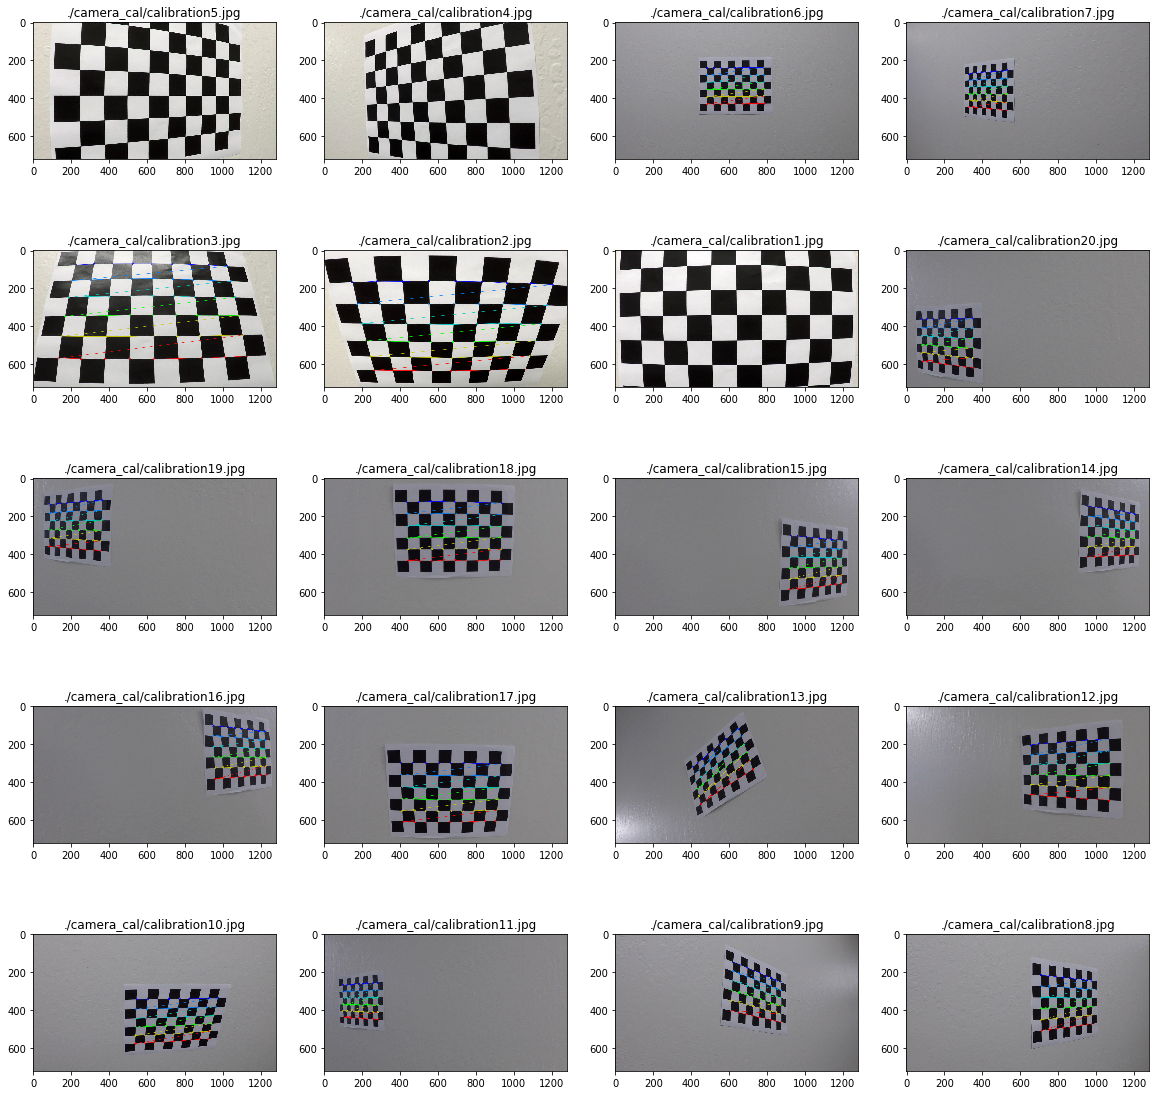

In [3]:
camCal = CalibrateCamera()

cal_images = camCal.getCalibrationImages()


f, ax = plt.subplots(5, 4, figsize=(20, 20))

ax = ax.ravel()

for cal_image,axi in zip(cal_images,ax):
    axi.imshow(cal_image[0])
    axi.set_title(cal_image[1])

plt.subplots_adjust(hspace=0.3)
plt.show()



## Threshold Functions

## Show Chessboard Undistorted

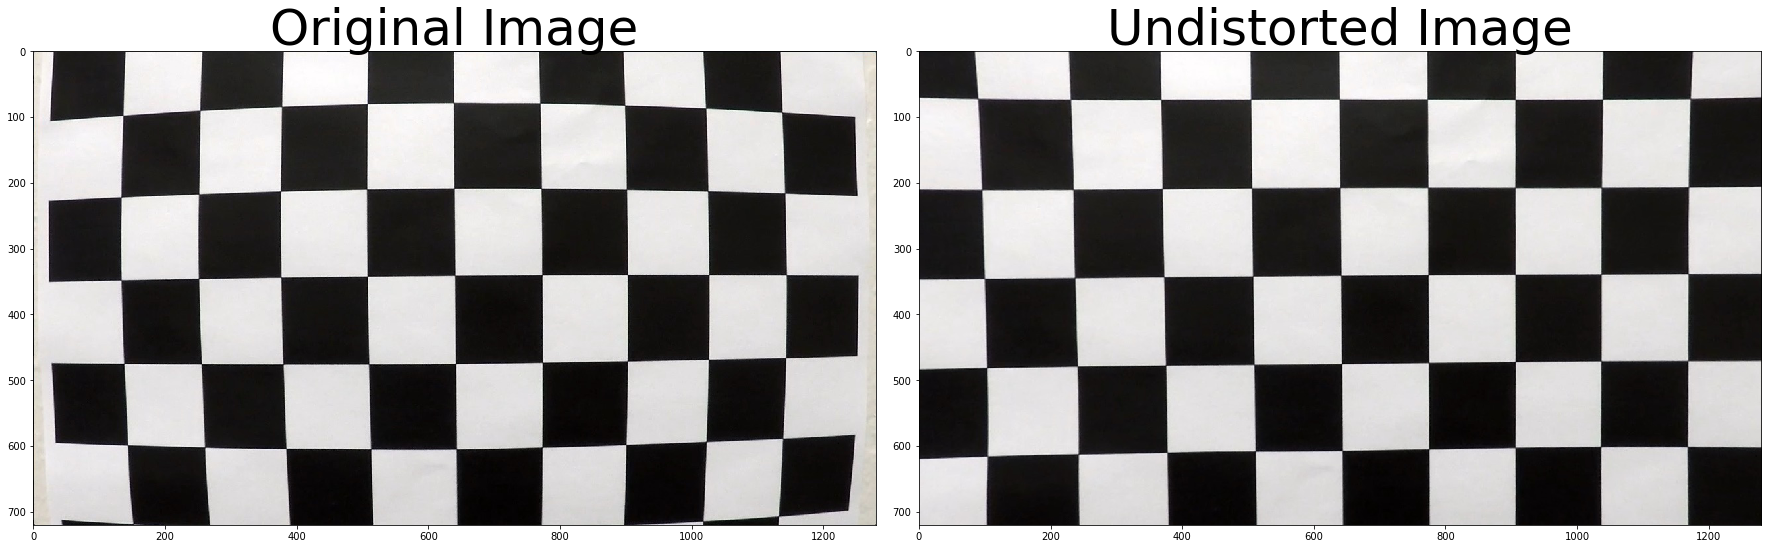

In [4]:
cal_image = mpimg.imread("./camera_cal/calibration1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort Test Image

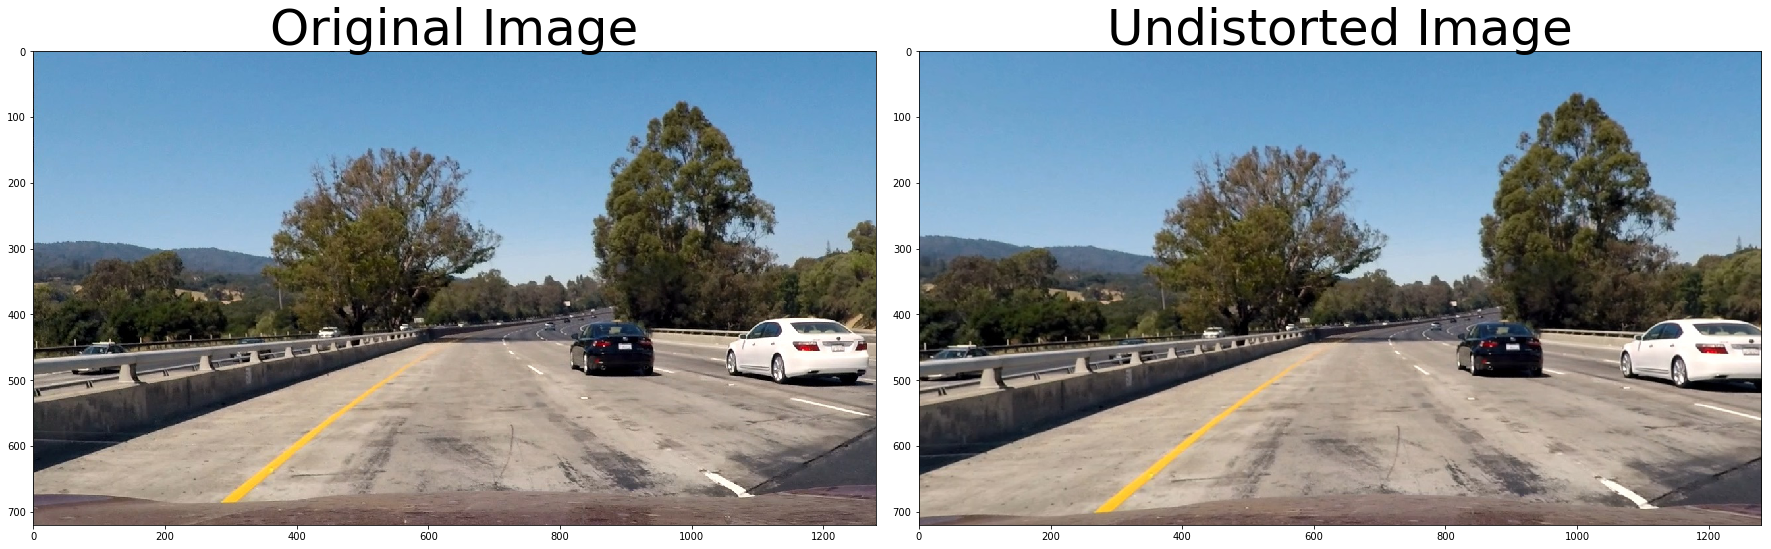

In [5]:
cal_image = mpimg.imread("./test_images/test1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient & Threshold functions


In [6]:

# Class that takes an image and lets you pick appropriate Channels from different
# Color spaces
class ImageChannel():
    image = None
    def __init__(self,img):
        # Initial RGB image
        self.image = img

    def getChannel(self, channel):
        """Dispatch method"""
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, channel, lambda: "nothing")
        # Call the method as we return it
        return method()

    def GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    def RGB_R(self):
        return image[:,:,0]

    def RGB_G(self):
        return image[:,:,1]

    def RGB_B(self):
        return image[:,:,2]

    def HLS_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HLS_L(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HLS_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    def HSV_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HSV_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HSV_V(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]

    
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel="GRAY", sobel_kernel=3, thresh=(0,255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, channel="GRAY", sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, channel="GRAY", sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh (img, channel="GRAY", thresh=(170,255)):
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)

    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary



## Gradient & Threshold Visualizations

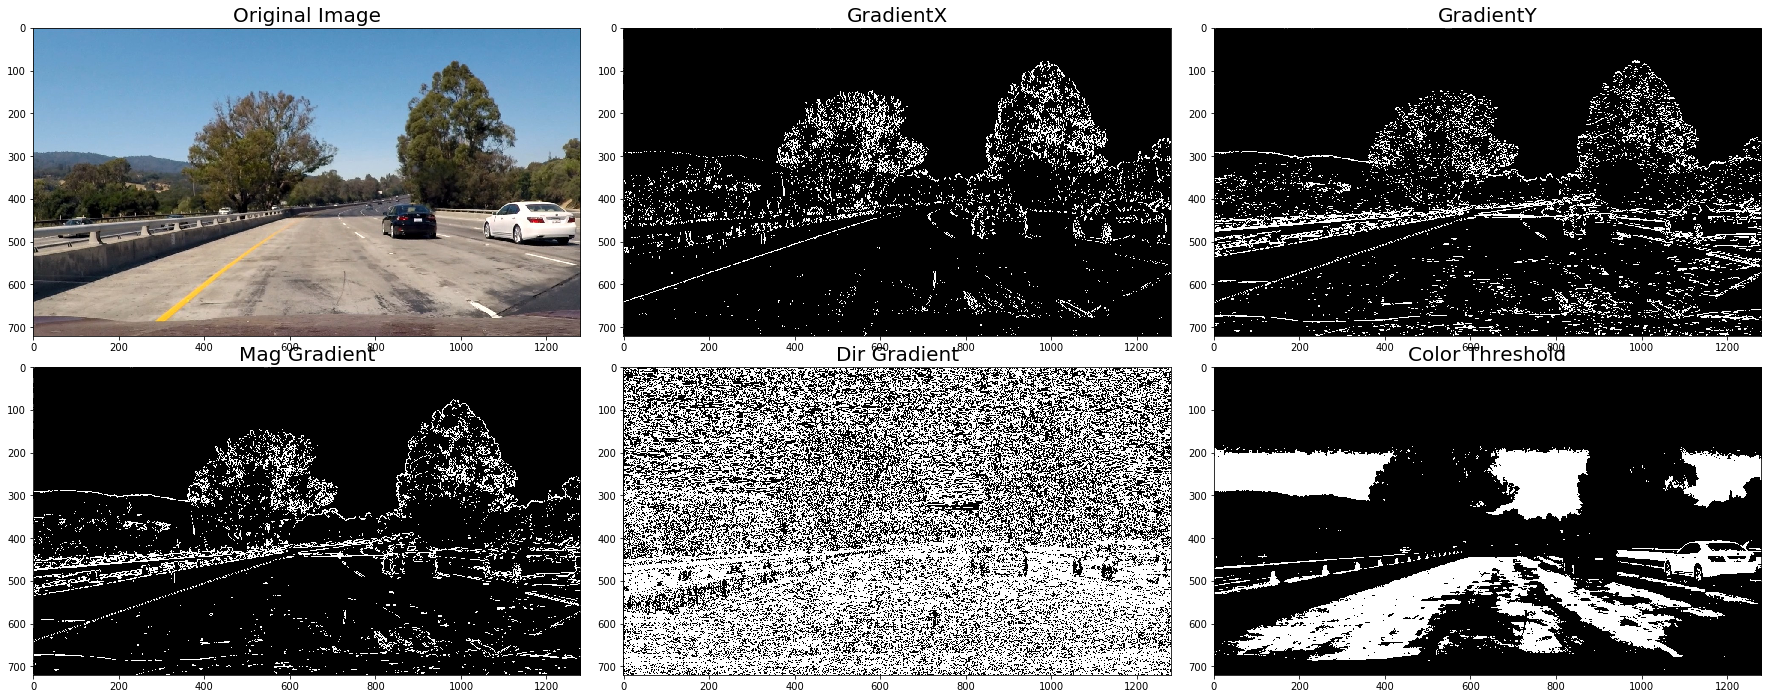

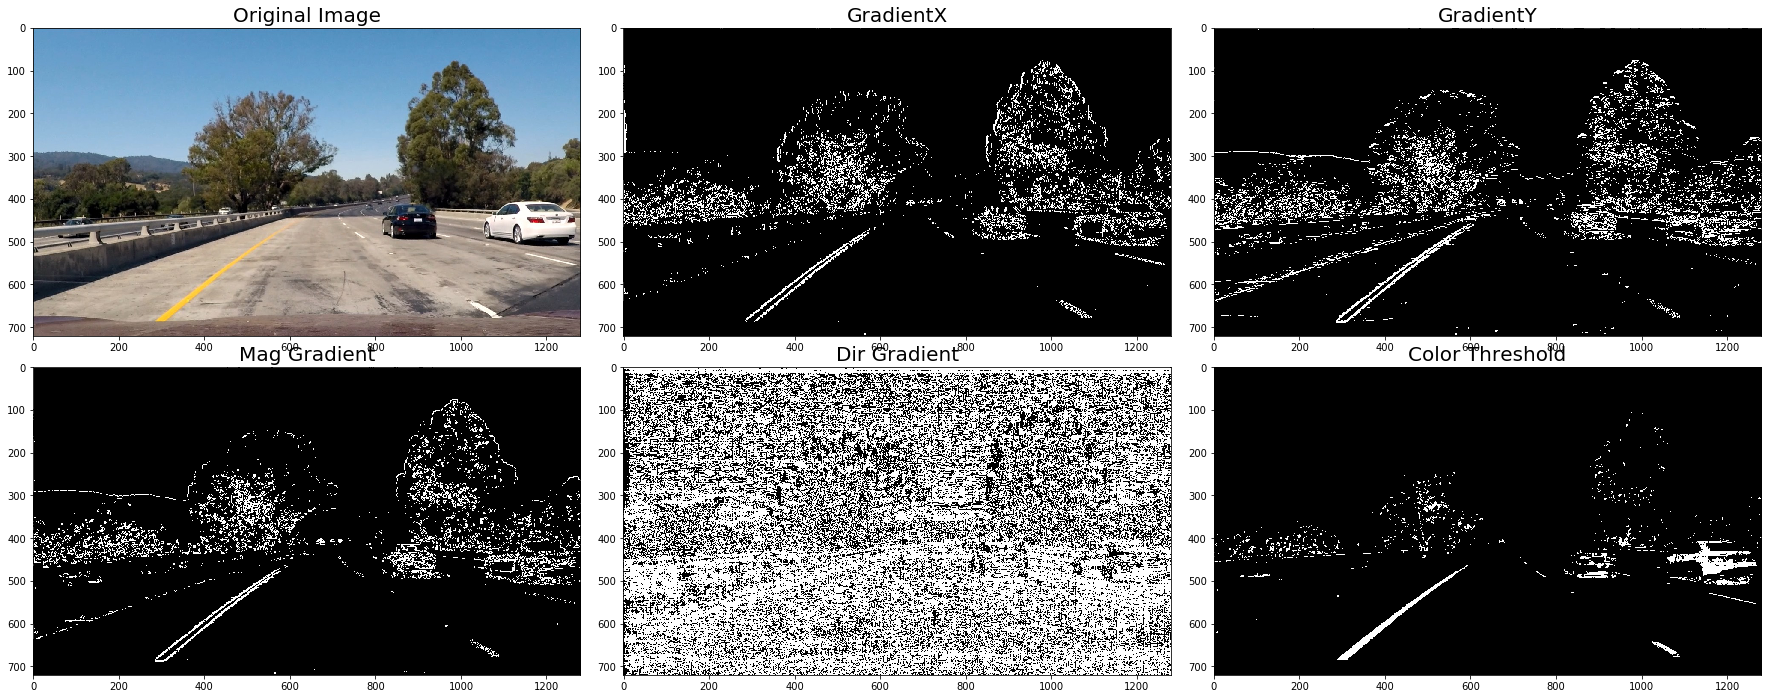

In [7]:
# Read in an image and grayscale it
ksize = 3
image = mpimg.imread('./test_images/test1.jpg')

gradx = abs_sobel_thresh(image, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="GRAY", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="GRAY", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="GRAY", thresh=(170,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

gradx = abs_sobel_thresh(image, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="HLS_S", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="HLS_S", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="HLS_S", thresh=(150,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

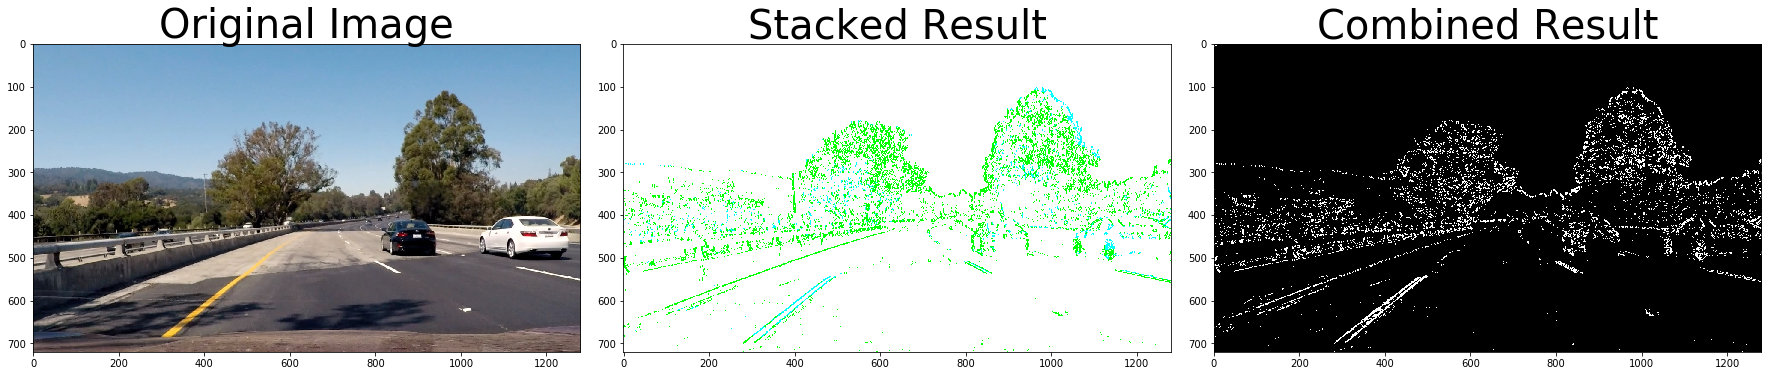

In [8]:
image = mpimg.imread('./test_images/test4.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    undistorted = camCal.undistortImage(img)


    gradx_g = abs_sobel_thresh(undistorted, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 150))
    grady_g = abs_sobel_thresh(undistorted, orient='y', channel="GRAY", sobel_kernel=15, thresh=(20, 150))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(15, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    #gradx_l = abs_sobel_thresh(undistorted, orient='x', channel="HLS_L", sobel_kernel=ksize, thresh=(20, 100))
    #gradx_s = abs_sobel_thresh(undistorted, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
    color_s = color_thresh(image, channel="HLS_S", thresh=(100, 255))
    color_l = color_thresh(image, channel="HLS_L", thresh=(220, 255))
    color_v = color_thresh(image, channel="HSV_V", thresh=(210, 255))

    #color_t = color_thresh(undistorted, channel="HLS_S", thresh=(150,255))


    color_binary = np.dstack(( np.zeros_like(gradx_g), gradx_g, color_s, gradx_g)) * 255
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[(gradx_l ==1) | (color_t ==1) | (gradx_s==1) ] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_l == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1


    return color_binary, combined_binary
    
stacked, combined = pipeline(image)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(stacked, cmap="gray")
ax2.set_title('Stacked Result', fontsize=40)

ax3.imshow(combined, cmap="gray")
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## Perspective Transform

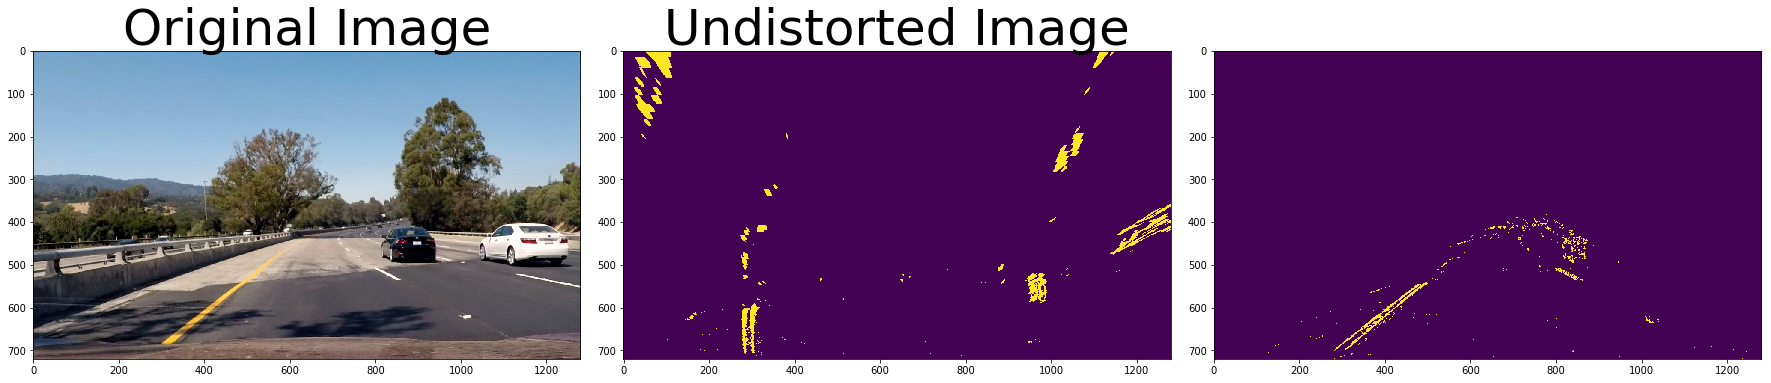

In [9]:
def get_transform_matrix():
    img = mpimg.imread('test_images/straight_lines1.jpg')
    h,w= img.shape[:2]

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])

#    src = np.float32(
#        [[685, 450], 
#          [1100, 710], 
#          [200, 710], 
#          [595, 450]])
#    
#    dst = np.float32(
#        [[900, 0], 
#          [900, 710], 
#          [250, 710], 
#          [250, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

# Remove a region of an image
def remove_region(img, triangle):
    mask = np.ones_like(img) 
    mask = cv2.fillPoly(mask, [triangle], 0)

    new_combined = np.zeros_like(img)
    new_combined[((img == 1) & (mask == 1))] = 1
    
    return new_combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cal_image = mpimg.imread("./test_images/test4.jpg")

stacked,processed = pipeline(cal_image)

# Remove a piece of the road between te lanes. This removes some noise that may be in between the lane lines
#h,w= processed.shape[:2]
#triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
#processed = remove_region(processed, triangle)
pHeightMask=1.7
imshape = cal_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/pHeightMask, imshape[0]/2), (imshape[1]/pHeightMask, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
processed = region_of_interest(processed,vertices)
    
M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(processed)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

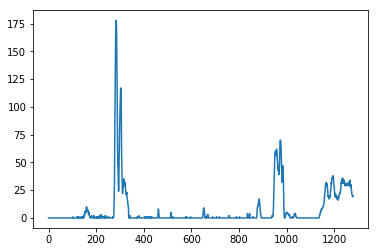

In [10]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Orig Sliding Window


(720, 0)

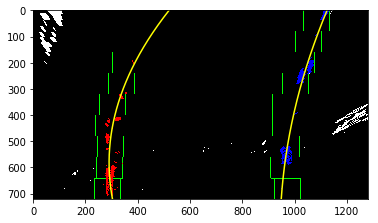

In [11]:
binary_warped = np.copy(warped)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#print ("Left Shape->",left_fit.shape, leftx.shape, lefty.shape)
#print ("Left-> ",left_fit, leftx, lefty)
#print ("Right-> ",right_fit, right_fitx)

## Sliding Window Search (CLASS)

In [42]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def updateLine(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.radius_of_curvature is None:
            diff = 0.0
        else:
            diff = abs(self.radius_of_curvature - radius)

        if (diff/radius > 0.8):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

            
        return resetWindow
        
    def updateLine_old(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)

        if (abs(diff[0]/fit[0]) > 0.3) | (abs(diff[1]/fit[1]) > 0.3) | (abs(diff[2]/fit[2]) > 0.3):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            resetWindow = True
        else:
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 5):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position
            
        return resetWindow

class SlidingWindow():
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def __init__(self):
        self.leftLine = Line()
        self.rightLine = Line()
        self.first_pass = True
        self.resetWindowParams ()
        return

    def resetWindowParams(self):
        print ("First Pass")
        self.leftLine = Line()
        self.rightLine = Line()
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty = None,None,None,None,None
        self.left_fit_cr, self.right_fit_cr = None, None
        self.nonzeroy, self.nonzerox = None, None
        return

    def polyfit(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            
        left_curverad, right_curverad= self.calc_curve()
        position = self.calc_lane_position(binary_warped)
        resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
        resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)

        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            left_curverad, right_curverad= self.calc_curve()
            position = self.calc_lane_position(binary_warped)

            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)
        return out_img
    
    def polyfit_old(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        return out_img

    def sliding_window_polyfit(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        return out_img

    def plot1(self,binary_warped, out_img, ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()
        
    def no_sliding_polyfit(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        return out_img
        #plt.imshow(out_img)
        #plt.plot(self.left_fitx, self.ploty, color='yellow')
        #plt.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()

    def calc_lane_position(self, image):
        center_pos = image.shape[1]/2.0
        lane_pos = (self.left_fitx[::-1][0] + self.right_fitx[::-2][0]) / 2.0
        return abs (lane_pos - center_pos) * self.xm_per_pix
    
    def calc_curve(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)


        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + self.left_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.left_fit_cr[0])
        right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + self.right_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad


    def plot_poly(self, binary_warped,ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-self.margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, 
                                      self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-self.margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+self.margin, 
                                      self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ax.imshow(result)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #ax.xlim(0, 1280)
        #ax.ylim(720, 0)
        
    def drawLane(self,warped,image, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        best_left_fit = self.leftLine.best_fit
        best_right_fit = self.rightLine.best_fit
        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([best_left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([best_right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def drawData(self,image):
        font = cv2.FONT_HERSHEY_PLAIN
        text = "Radius: %.2f km" % ((self.leftLine.radius_of_curvature + self.rightLine.radius_of_curvature)/2000.0)
        cv2.putText(image,text,(30,50),font, 2, (0,0,255), 2, cv2.LINE_AA)
        text = "Position: %.2f m" % (self.leftLine.line_base_pos)
        cv2.putText(image,text,(1000,50),font, 2, (0,0,255), 2, cv2.LINE_AA)

        return image
        


First Pass


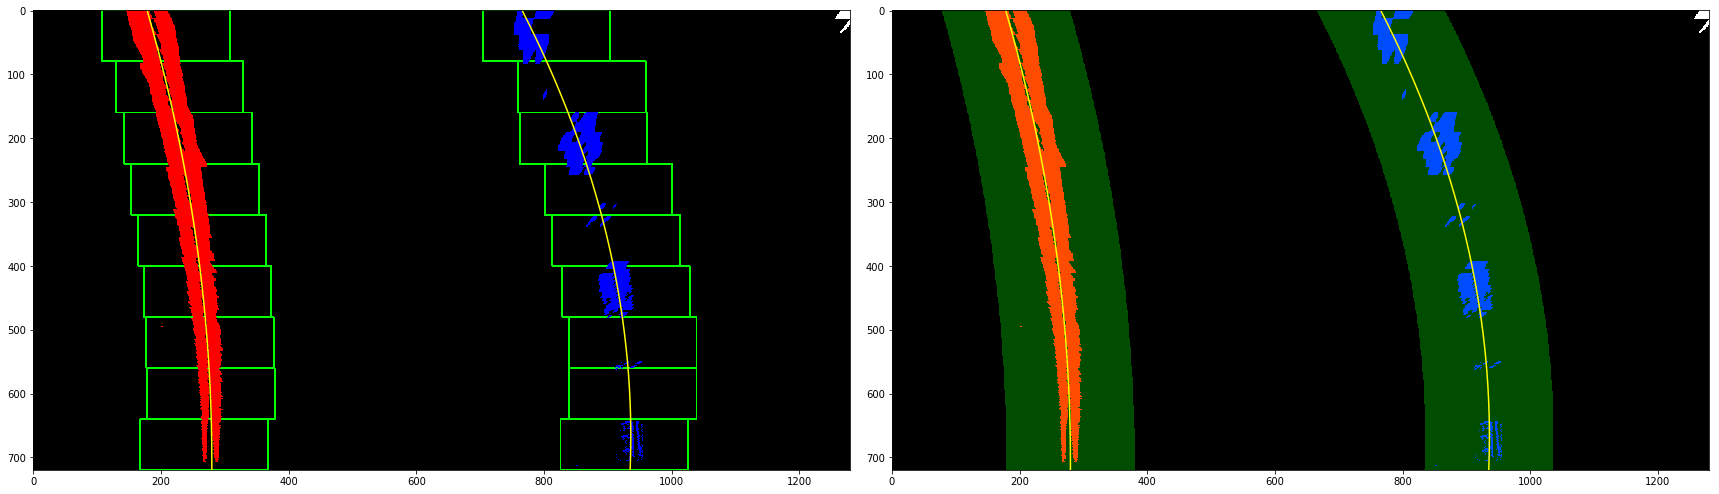

811.3646477070439 m 429.72995669848956 m


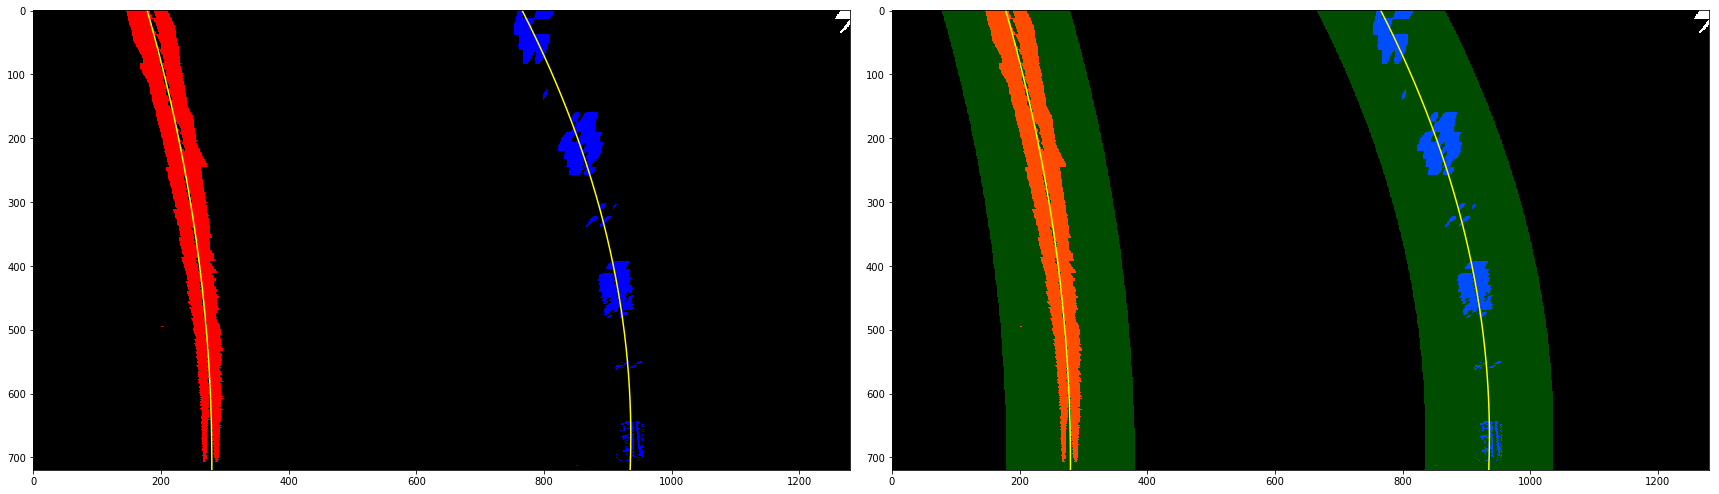

811.3646477069292 m 429.7299566983702 m


In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()        
binary_warped = np.copy(warped)
slideW = SlidingWindow()
out_img = slideW.sliding_window_polyfit(binary_warped)
slideW.plot1(binary_warped,out_img, ax1)


result = slideW.plot_poly(binary_warped,ax2)


plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

image = mpimg.imread('./test_images/test6.jpg')
stacked, combined = pipeline(image)

M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()       
binary_warped = np.copy(warped)

out_img = slideW.no_sliding_polyfit(binary_warped)
slideW.plot1(binary_warped,out_img,ax1)


result = slideW.plot_poly(binary_warped,ax2)

plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')

First Pass
./test_images/test1.jpg
First Pass


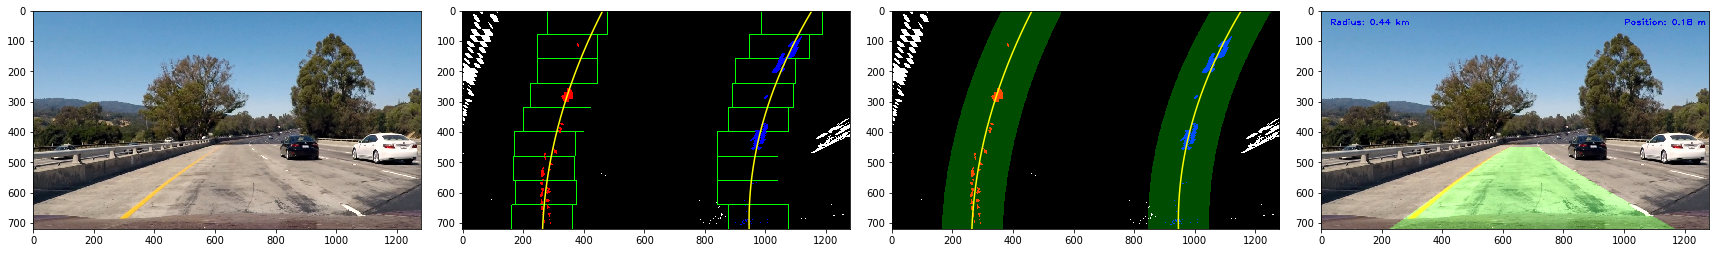

506.5377999561467 m 382.1241170034206 m
./test_images/test2.jpg
Old: 382.1241170034206  New: 173.84338918401716 Diff: 208.28072781940347
First Pass


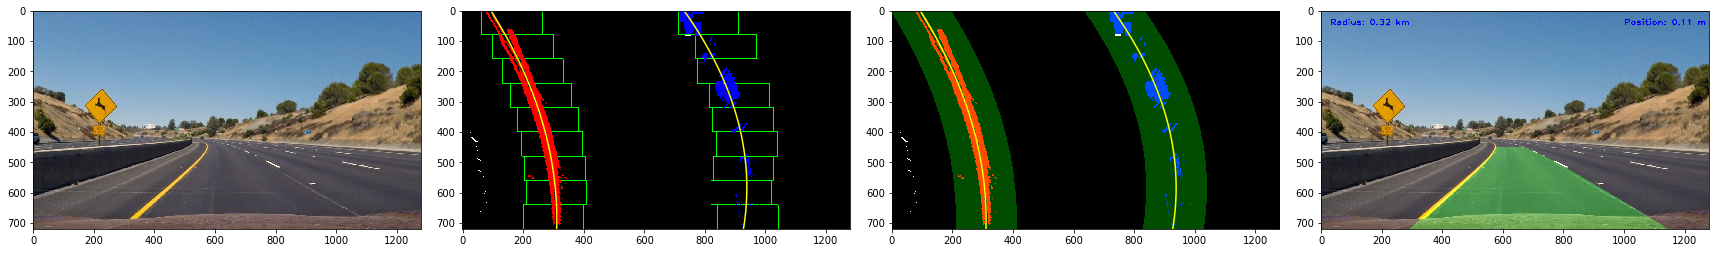

360.37077584987844 m 271.43553735291715 m
./test_images/test3.jpg
Old: 360.37077584987844  New: 126.22536147819307 Diff: 234.14541437168538
First Pass


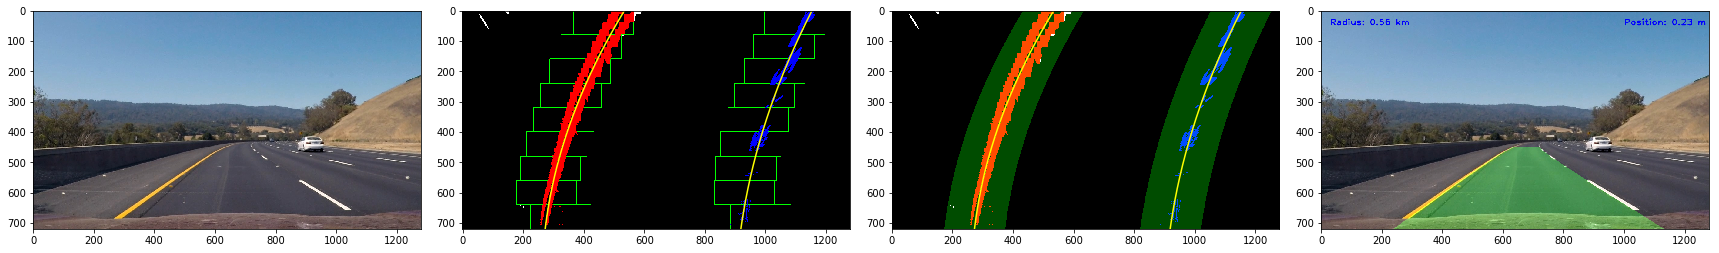

484.2807005213424 m 639.5738319588494 m
./test_images/test4.jpg
Old: 484.2807005213424  New: 250.28691604733064 Diff: 233.99378447401176
First Pass


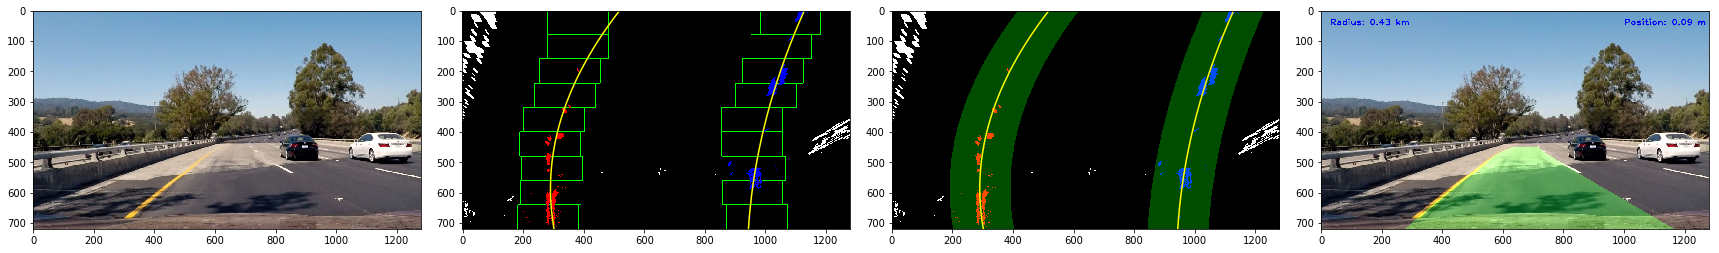

248.85572798478606 m 619.2172746577113 m
./test_images/test5.jpg
Old: 619.2172746577113  New: 331.4001782594185 Diff: 287.8170963982928
First Pass


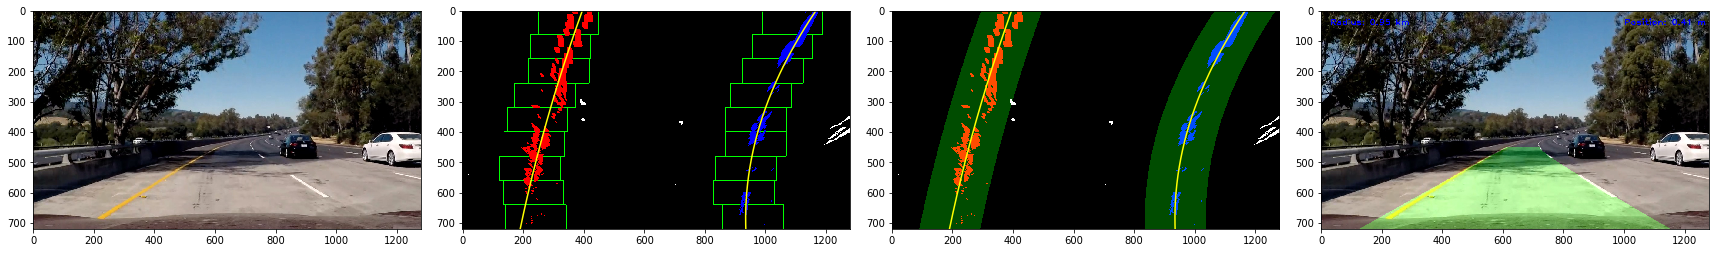

1568.3403528269382 m 332.7200654627532 m
./test_images/test6.jpg


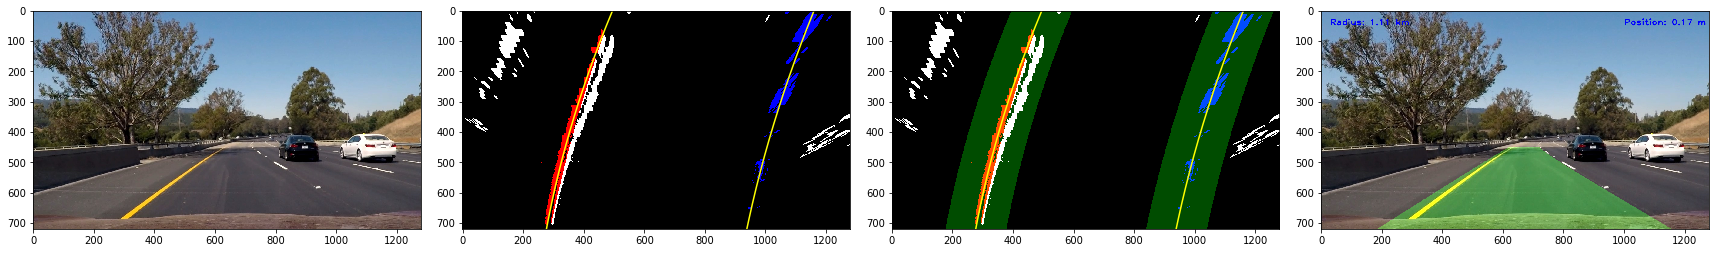

1021.3453866629367 m 1196.9565338321743 m
./test_images/test7.jpg
Old: 1196.9565338321743  New: 407.541283305612 Diff: 789.4152505265622
First Pass


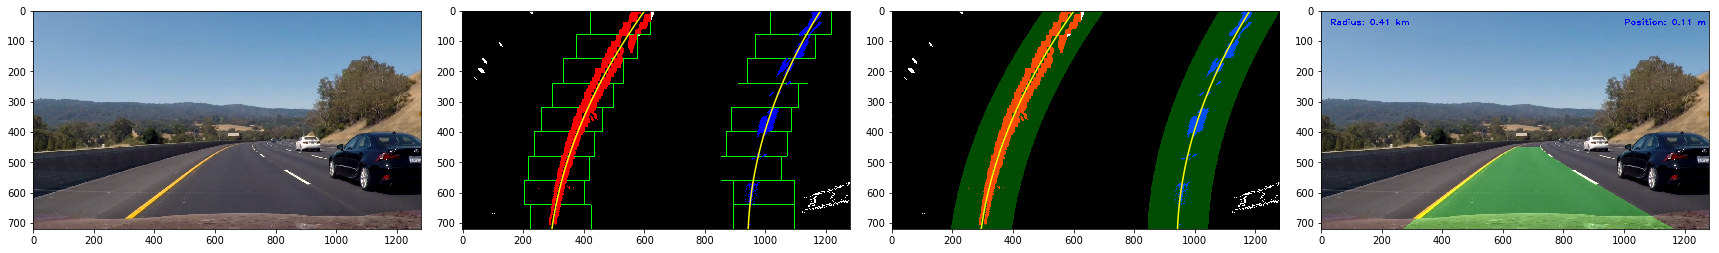

414.8724008180385 m 407.54128330582716 m
./test_images/test8.jpg


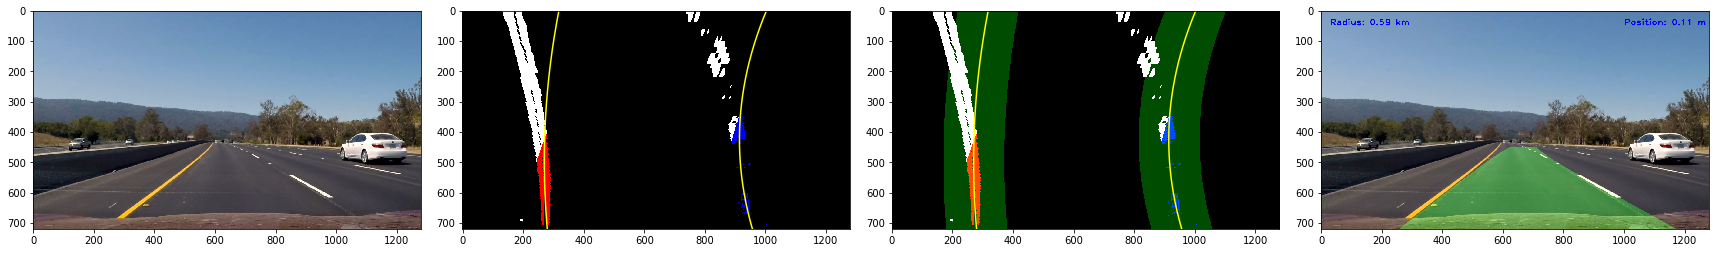

842.2117927419743 m 334.42688621061205 m
./test_images/test9.jpg


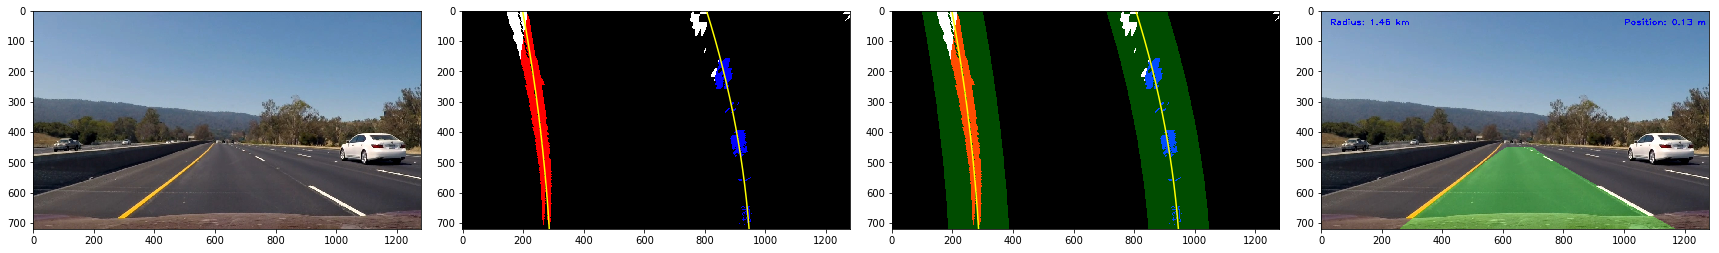

1920.3257777492327 m 991.8524797034316 m


In [47]:
images = glob.glob("./test_images/test*.jpg")

slide = SlidingWindow()
for n in range(1,10):

    fname = "./test_images/test%d.jpg" % n
    print (fname)
    image = mpimg.imread(fname)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    f, ax = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout() 
    ax[0].imshow(image)
    binary_warped = np.copy(warped)

    out_img = slide.polyfit(binary_warped)

    slide.plot1(binary_warped,out_img,ax[1])

    result = slide.plot_poly(binary_warped,ax[2])

    lanes = slide.drawLane(binary_warped,image,Minv)
    lanes = slide.drawData(lanes)

    ax[3].imshow(lanes)

    plt.show()

    left_curverad, right_curverad= slide.calc_curve()

    print(left_curverad, 'm', right_curverad, 'm')

In [ ]:
videoSlide = SlidingWindow()


def process_image(image):

    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    binary_warped = np.copy(warped)

    out_img = videoSlide.polyfit(binary_warped)

    lanes = videoSlide.drawLane(binary_warped,image,Minv)

    lanes = videoSlide.drawData(lanes)
    return lanes

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## Convolutional Approach
(Not Used, just for experimentation. Didn't seem as good as previous)

## Perspective Transform
